In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from diffpy.pdfgui.tui import LoadProject
from diffpy.pdfgui.control.pdfguicontrol import PDFGuiControl
from diffpy.pdffit2.pdffit2 import calculationError

from IPython.display import clear_output
import time
# from tqdm.auto import tqdm

In [2]:
%matplotlib widget

In [3]:
def tqdm_sleep_sec(t, message='Sleep'):
    import datetime
    from tqdm import tqdm
    now = datetime.datetime.now()
    print(f'\nSleep for a while: {t} seconds.')
    print(f'Waiting starts at {now}')
    for i in tqdm(range(0,100), desc=message):
        time.sleep(t/100)

## Load a pre-defined PDFGui project file (.ddp) using diffpy.pdfgui.tui.LoadProject

In [4]:
fn_dir = '/Users/cheng-hunglin/Documents/Data_LDRD'
fn = os.path.join(fn_dir, 'Cs_x-Pb_y-B_z_serial_bkg_10min_11-1.ddp3')
ddp = LoadProject(fn)

## Check the fitting object (diffpy.pdfgui.control.fitting.Fitting) in the ddp project file

In [5]:
fit_demo = ddp.getFits()[21]
fit_demo.name

'Fit 3 _0D_s20'

In [6]:
fit_demo.owner

In [7]:
fit_demo.name = 'Fit 3 _0D_s20 demo'

In [8]:
fit_demo.name

'Fit 3 _0D_s20 demo'

## Create an object of PDFGuiControl which holds all the data GUI needs to access or change

### the PDFGuiControl object will be saved as a ddp file in the end

In [9]:
new_guicontrol = PDFGuiControl()

## Copy the Fitting object from ddp to the new PDFGuiControl

In [10]:
new_guicontrol.add(fit_demo.copy())

In [11]:
# dir(new_guicontrol)

## Using PDFGuiControl.fits to check the added Fitting object in the the new PDFGuiControl

In [12]:
new_guicontrol.fits

## Find the gr data list and sort it

In [13]:
# subpath = '/Users/cheng-hunglin/Documents/Data_LDRD'
subpath = '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/bkg_10min/gr_updated'
gr_dir = os.path.join(subpath)
gr_list = glob.glob(gr_dir + '/*.gr')
gr_list.sort()

In [14]:
gr_serial = gr_list[:]
# gr_serial

## Define fitrmax, fitrmin, qdamp, qbroad from the copied Fitting object, e.g., fit_demo.copy()

In [15]:
fitrmax = new_guicontrol.fits[0].datasets[0].fitrmax
fitrmin = new_guicontrol.fits[0].datasets[0].fitrmin
qdamp = new_guicontrol.fits[0].datasets[0].qdamp
qbroad = new_guicontrol.fits[0].datasets[0].qbroad
# new_guicontrol.fits[0].datasets[1].constraints.update(new_guicontrol.fits[0].datasets[0].constraints)

## Check fitting parameters

In [16]:
new_guicontrol.fits[0].parameters

{1: <diffpy.pdfgui.control.parameter.Parameter at 0x11fdb68d0>,
 2: <diffpy.pdfgui.control.parameter.Parameter at 0x11fdb6ad0>,
 3: <diffpy.pdfgui.control.parameter.Parameter at 0x11fdb67d0>,
 100: <diffpy.pdfgui.control.parameter.Parameter at 0x11fdb6450>,
 101: <diffpy.pdfgui.control.parameter.Parameter at 0x11fdb6dd0>,
 6: <diffpy.pdfgui.control.parameter.Parameter at 0x11fdb6b50>,
 40: <diffpy.pdfgui.control.parameter.Parameter at 0x11fdb69d0>,
 41: <diffpy.pdfgui.control.parameter.Parameter at 0x12a13b9d0>,
 202: <diffpy.pdfgui.control.parameter.Parameter at 0x12a13b8d0>,
 43: <diffpy.pdfgui.control.parameter.Parameter at 0x11fdb6850>,
 300: <diffpy.pdfgui.control.parameter.Parameter at 0x12a13b950>,
 200: <diffpy.pdfgui.control.parameter.Parameter at 0x12a13bf50>,
 50: <diffpy.pdfgui.control.parameter.Parameter at 0x12a13bad0>,
 51: <diffpy.pdfgui.control.parameter.Parameter at 0x12a13ba50>,
 201: <diffpy.pdfgui.control.parameter.Parameter at 0x12a13b350>,
 4: <diffpy.pdfgui.cont

In [17]:
new_guicontrol.fits[0].parameters[1].fixed

False

In [18]:
# new_guicontrol.fits[0].parameters[1].fixed = True

In [19]:
# new_guicontrol.fits[0].parameters[1].fixed

## Make the fitting tree in the new PDFGuiControl

In [20]:
for i in range(len(gr_serial)):

    ## Add new Fitting by copying the existed Fitting object
    new_guicontrol.add(fit_demo.copy())

    ## Rename the copied Fitting object
    new_guicontrol.fits[i+1].name = f'Fit_s{i+1:02d}'

    ## Load gr data from gr_serial to the newly copied Fitting object
    new_guicontrol.loadDataset(new_guicontrol.fits[i+1], gr_serial[i])

    ## Delete the old dataset in the newly copied Fitting object  
    new_guicontrol.fits[i+1].datasets.__delitem__(0)

    ## Update fitrmax, fitrmin, qdamp, qbroad in the loaded dataset
    new_guicontrol.fits[i+1].datasets[0].fitrmax = 45 #fitrmax
    new_guicontrol.fits[i+1].datasets[0].fitrmin = 2.4 #fitrmin
    new_guicontrol.fits[i+1].datasets[0].qdamp = qdamp
    new_guicontrol.fits[i+1].datasets[0].qbroad = qbroad

    ## Update the constraints for the loaded dataset, mainly for dscale, qdamp, qbroad if constrained
    new_guicontrol.fits[i+1].datasets[0].constraints.update(deepcopy(new_guicontrol.fits[0].datasets[0].constraints))

    ## Equal the amount of scale factor
    # num_struc = len(new_guicontrol.fits[0].strucs)
    # for j in range(num_struc):
    #     new_guicontrol.fits[i+1].strucs[j].setvar('pscale', 1/num_struc)
    new_guicontrol.fits[i+1].parameters[100].setInitial(0.33)  #0.615)
    new_guicontrol.fits[i+1].parameters[101].setInitial(0.33)  #0.615)
    
    new_guicontrol.fits[i+1].parameters[300].setInitial(0.5)


In [21]:
len(new_guicontrol.fits)

38

In [22]:
new_guicontrol.fits[i+1].strucs[1].getvar('pscal')

1.0

In [23]:
new_guicontrol.fits[i+1].parameters[100].initialValue()

0.33

In [24]:
new_guicontrol.fits[1].datasets[0].constraints

{'dscale': <diffpy.pdfgui.control.constraint.Constraint at 0x345e04bf0>}

In [25]:
len(new_guicontrol.fits)

38

## Run all the fitting in the new PDFGuiControl

## First fitting - Refine scales and lattice parameters

In [26]:
## Fitting parameters of lattice parameter in a list
lat_par_list = [1 ,2 ,3, 4, 5, 6]

In [27]:
## The total # of Fitting object in the new PDFGuiControl will be len(gr_list) + 1
## because of the first one is from the pre-defined ddp and has no modification 
# for i in range(2):
# for i in tqdm(range(len(gr_serial)+1), desc =f'batch fitting with pdffit2'):
failed_list = []
for i in range(1, len(new_guicontrol.fits)):
    
    clear_output(wait=True)
    
    data_name = new_guicontrol.fits[i].datasets.keys()[0]
    print(f'{i = }\n')
    print(f'Data {data_name[:28]} fitting is on going\n')

    ## Free lattice parameters for fitting
    for k in lat_par_list:
        # ddp_01.getFits()[i].parameters[k].fixed = False
        new_guicontrol.fits[i].parameters[k].fixed = False 
    
    try:
        new_guicontrol.fits[i].run()

        print('\n')
        print('Update refined results to initial for the current dataset\n')
        for key, item in new_guicontrol.fits[i].parameters.items():
            refined = new_guicontrol.fits[i].getData(key)
            new_guicontrol.fits[i].parameters[key].setInitial(refined)

    except calculationError:
        new_guicontrol.fits[i].stop()
        failed_list.append(data_name)
        print(f'Data {data_name[:28]} fitting fialed\n')
        
        
        tqdm_sleep_sec(30, message=f'fitting failed: {i = }, {data_name}')
    
    print('\n')
    time.sleep(3)


i = 37

Data Cs_rich_1-0-1_v2_20250606-18 fitting is on going


******************************************************************************
*                      P D F F I T   Version   1.5.1                         *
*                                              2025-02-07                    *
* -------------------------------------------------------------------------- *
* (c) 1998-2007 Trustees of the Michigan State University.                   *
* (c) 2008-2025 Trustees of the Columbia University                          *
*               in the city of New York.                                     *
*                                                                            *
* Authors:                                                                   *
*     Thomas Proffen        -   Email: tproffen@lanl.gov                     *
*     Jacques Bloch         -   Email: bloch@pa.msu.edu                      *
*     Christopher Farrow    -   Email: clf2121@columbia.edu        

In [28]:
i

37

## Save the new PDFGuiControl as a ddp file

In [54]:
subpath = '/Users/cheng-hunglin/Documents/Data_LDRD'
fn01 = 'Cs_x-Pb_y-B_z_serial_bkg_10min_21.ddp'
full_fn01 = os.path.join(subpath, fn01)

new_guicontrol.save(projfile=full_fn01)

## Plot rw for all fittins

In [79]:
rw_list = []
for i in range(len(new_guicontrol.fits)):
    rw = new_guicontrol.fits[i].getData('rw')
    rw_list.append(rw)

In [80]:
len(rw_list)

38

In [86]:
idx = np.arange(0, 38, 1)

In [87]:
idx.shape

(38,)

Text(0, 0.5, 'rw')

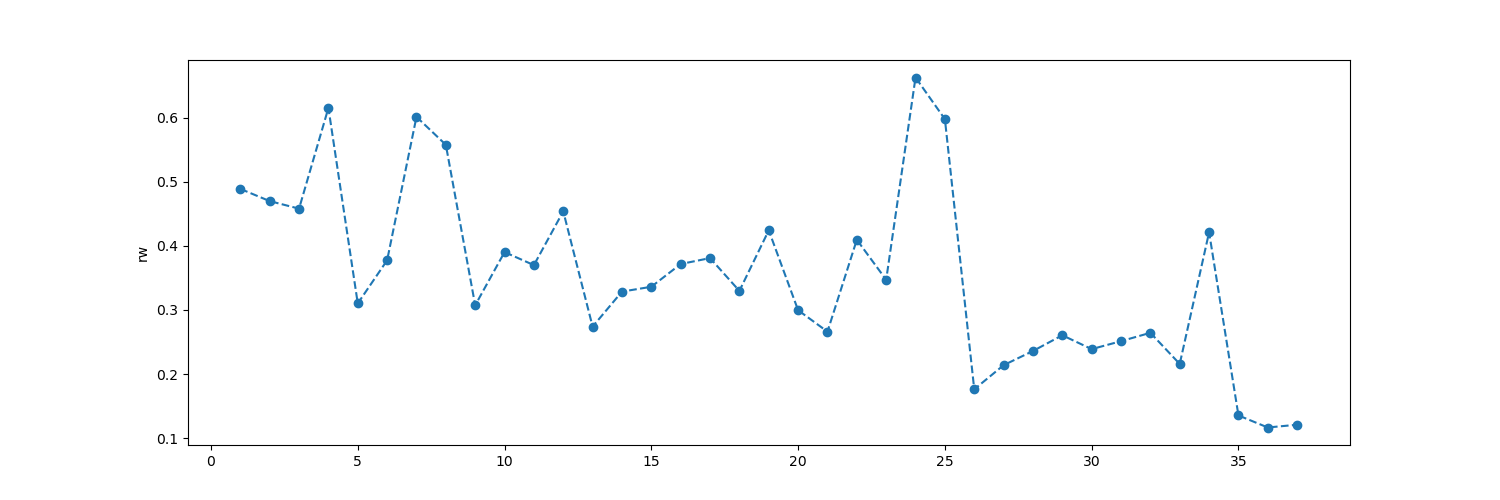

In [88]:
f = plt.figure(figsize=(15,5))
ax = f.gca()
ax.plot(idx, rw_list, 'o--')
ax.set_ylabel('rw')

## 2nd fitting - Refine Debye–Waller factor (Anisotropic displacement parameter, ADP)

In [57]:
full_fn01

'/Users/cheng-hunglin/Documents/Data_LDRD/Cs_x-Pb_y-B_z_serial_bkg_10min_21.ddp'

In [58]:
# fn = '/Users/cheng-hunglin/Documents/Data_LDRD/Cs_x-Pb_y-B_z_serial_all6-1.ddp'
ddp_01 = LoadProject(full_fn01)

In [59]:
len(ddp_01.getFits())

38

In [60]:
ddp_01.getFits()[0].datasets.keys()[0]

'Cs_060_Br_120_Pb_060_PF_020_Tol_1200_20250606-233737_992618_scattering-1_mean_q.gr'

In [61]:
ddp_01.getFits()[0].getData(1)

In [62]:
# ddp_01.getFits()[0].parameters[1].fixed = False

In [63]:
## Fitting parameters of Debye–Waller factor in a list
ADP_par_list = [40, 41, 43, 60, 61, 62]

In [64]:
## The total # of Fitting object in the new PDFGuiControl will be len(gr_list) + 1
## because of the first one is from the pre-defined ddp and has no modification 
# for i in range(2):
# for i in tqdm(range(len(gr_serial)+1), desc =f'batch fitting with pdffit2'):
failed_list = []
for i in range(len(ddp_01.getFits())):
    
    clear_output(wait=True)
    
    data_name = ddp_01.getFits()[i].datasets.keys()[0]
    print(f'{i = }\n')
    print(f'Data {data_name[:28]} fitting is on going\n')

    ## Free lattice parameters for fitting
    for k in ADP_par_list:
        ddp_01.getFits()[i].parameters[k].fixed = False
        # new_guicontrol.fits[i+1].parameters[k].fixed = False    
    
    try:
        ddp_01.getFits()[i].run()

        print('\n')
        print('Update refined results to initial for the current dataset\n')
        for key, item in ddp_01.getFits()[i].parameters.items():
            refined = ddp_01.getFits()[i].getData(key)
            ddp_01.getFits()[i].parameters[key].setInitial(refined)

    except calculationError:
        ddp_01.getFits()[i].stop()
        failed_list.append(data_name)
        print(f'Data {data_name[:28]} fitting fialed\n')

        
        tqdm_sleep_sec(30, message=f'fitting failed: {i = }, {data_name}')
    
    print('\n')
    time.sleep(3)


i = 37

Data Cs_rich_1-0-1_v2_20250606-18 fitting is on going


******************************************************************************
*                      P D F F I T   Version   1.5.1                         *
*                                              2025-02-07                    *
* -------------------------------------------------------------------------- *
* (c) 1998-2007 Trustees of the Michigan State University.                   *
* (c) 2008-2025 Trustees of the Columbia University                          *
*               in the city of New York.                                     *
*                                                                            *
* Authors:                                                                   *
*     Thomas Proffen        -   Email: tproffen@lanl.gov                     *
*     Jacques Bloch         -   Email: bloch@pa.msu.edu                      *
*     Christopher Farrow    -   Email: clf2121@columbia.edu        

In [65]:
i

37

In [66]:
# ddp_01.getFits()[i].stop()

## Save the new PDFGuiControl as a ddp file

In [67]:
subpath = '/Users/cheng-hunglin/Documents/Data_LDRD'
fn02 = 'Cs_x-Pb_y-B_z_serial_bkg_10min_22.ddp'
full_fn02 = os.path.join(subpath, fn02)

ddp_01.save(full_fn02)

## Plot rw for all fittins

In [92]:
rw_list = []
for i in range(len(ddp_01.getFits())):
    rw = ddp_01.getFits()[i].getData('rw')
    rw_list.append(rw)

In [93]:
len(rw_list)

38

In [94]:
idx = np.arange(0, 38, 1)

In [95]:
idx.shape

(38,)

Text(0, 0.5, 'rw')

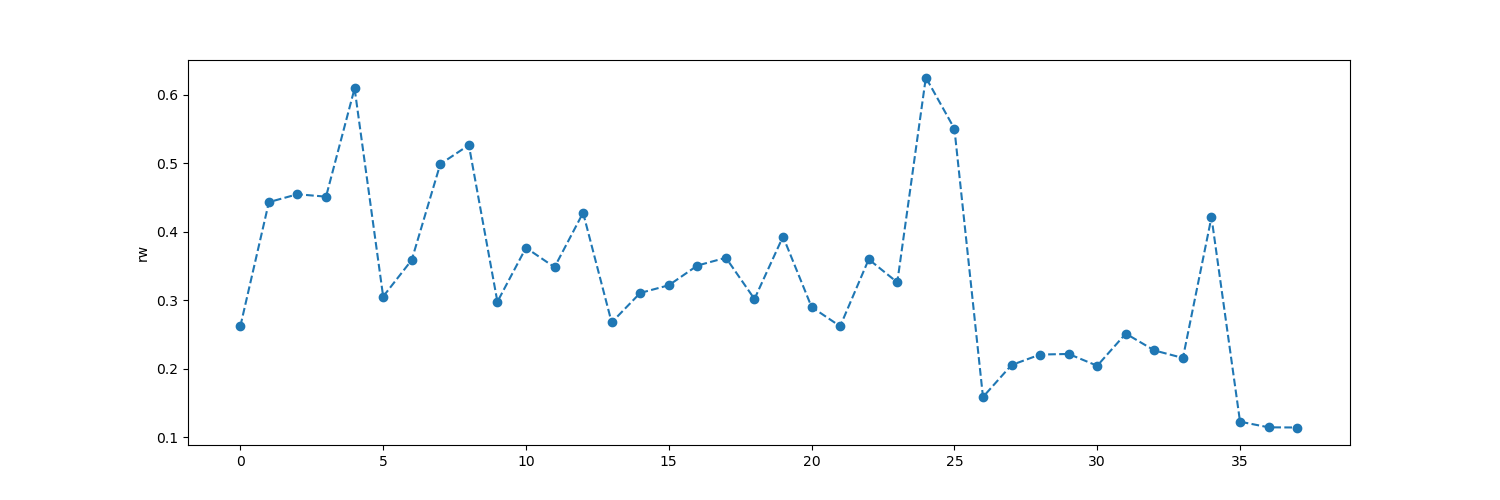

In [96]:
f = plt.figure(figsize=(15,5))
ax = f.gca()
ax.plot(idx, rw_list, 'o--')
ax.set_ylabel('rw')

## 3rd fitting - Refine atomic positions

In [ ]:
full_fn02

In [ ]:
# fn = '/Users/cheng-hunglin/Documents/Data_LDRD/Cs_x-Pb_y-B_z_serial_all6-1.ddp'
ddp_02 = LoadProject(full_fn02)

In [ ]:
len(ddp_02.getFits())

In [ ]:
ddp_02.getFits()[0].datasets.keys()[0]

In [ ]:
ddp_02.getFits()[0].getData(1)

In [ ]:
# ddp_02.getFits()[0].parameters[1].fixed = False

In [ ]:
## Fitting parameters of atomic positions in a list
xyz_par_list = []

In [ ]:
failed_list = []
for i in range(len(ddp_02.getFits())):
    
    clear_output(wait=True)
    
    data_name = ddp_02.getFits()[i].datasets.keys()[0]
    print(f'{i = }\n')
    print(f'Data {data_name[:28]} fitting is on going\n')

    ## Free atomic positions for fitting
    for k in xyz_par_list:
        ddp_02.getFits()[i].parameters[k].fixed = False
    
    try:
        ddp_02.getFits()[i].run()

        print('\n')
        print('Update refined results to initial for the current dataset\n')
        for key, item in ddp_02.getFits()[i].parameters.items():
            refined = ddp_02.getFits()[i].getData(key)
            ddp_02.getFits()[i].parameters[key].setInitial(refined)
        
    except calculationError:
        ddp_02.getFits()[i].stop()
        failed_list.append(data_name)
        print(f'Data {data_name[:28]} fitting fialed\n')
        
        
        tqdm_sleep_sec(30, message=f'fitting failed: {i = }, {data_name}')
    
    print('\n')
    time.sleep(3)

In [ ]:
# ddp_02.getFits()[i].stop()

In [ ]:
subpath = '/Users/cheng-hunglin/Documents/Data_LDRD'
fn03 = 'Cs_x-Pb_y-B_z_serial_bkg_10min_13.ddp'
full_fn03 = os.path.join(subpath, fn03)

ddp_02.save(full_fn03)

In [ ]:
failed_list